# CMSC320 Fall 2017 Final Tutorial
### Alexander Chiang

## 1. Introduction

My tutorial will serve as a step-by-step guide for beginners interested in the data science pipeline. In this tutorial, I will show the process I use to find, wrangle, analyze, and finally draw conclusions from data. The data I will use will be from University of Maryland's football team. Specifically, I will analyze individual player skills and stats (height, weight, passing, rushing, and/or player ranking) and how great of an impact individual skills have on Maryland's team.

The height and weight of a player is self-explanatory: coaches want bigger, stronger, players on their teams. A special stastic used only for quarterbacks is a passer rating, which is calculated based on passing attempts, completions, yards, touchdowns, and interceptions. Another special stat is a player's rank or "star rating", with a maximum of five stars. This is given to a high school prospect/recruit and is based on their talent relative to peers.

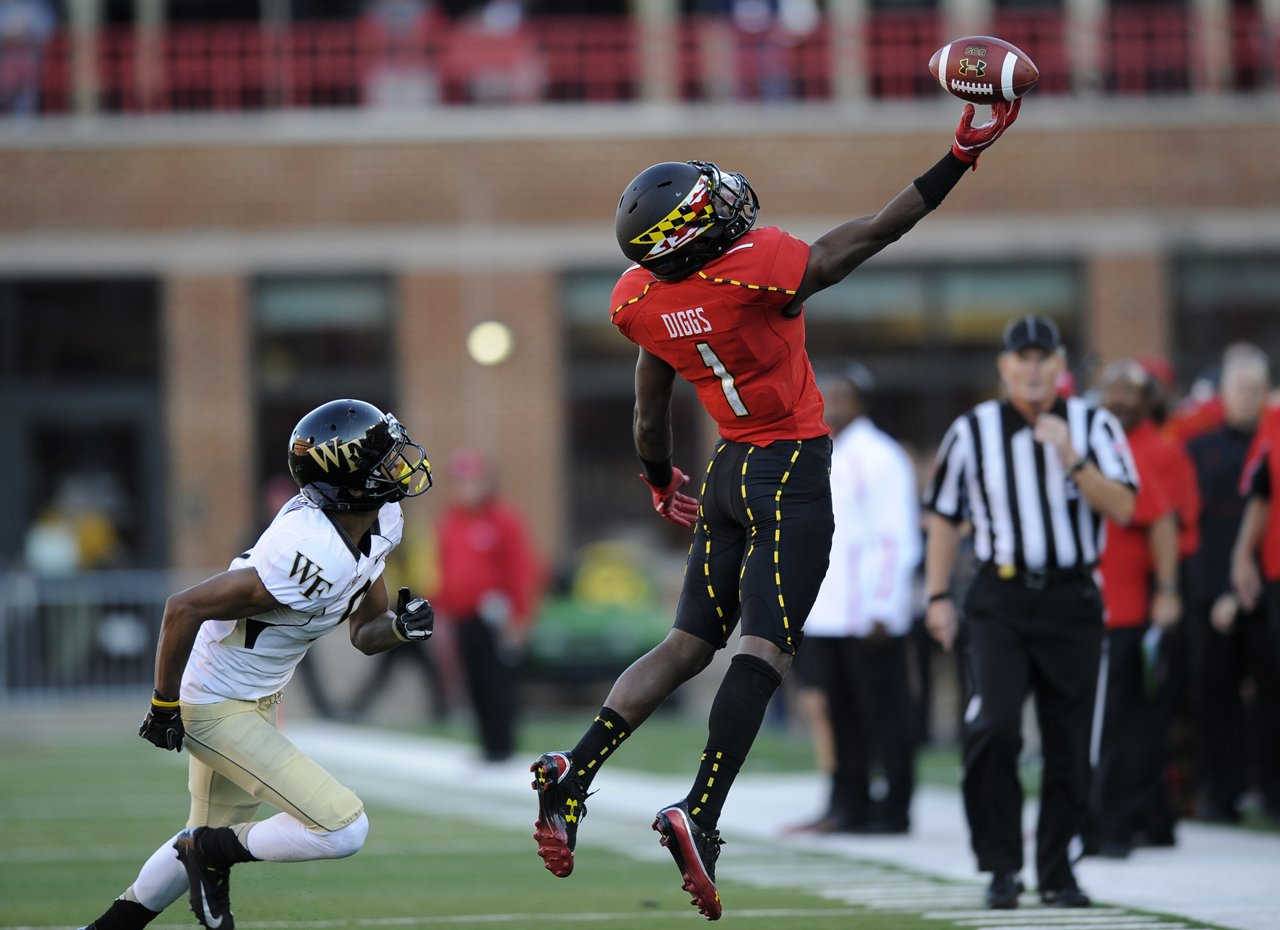

## 2. Data Wrangling

I found a majority of our data from University of Maryland's Athletics website. The site had tons of detailed statistics and player data since 2006. Because it was near impossible to find data before 2006, I made that the cutoff. I also supplemented that data with other websites that were easier to read/scrape, such as win/loss and star rankings.

I begin by calculating each season's win percentage.

In [1]:
import requests
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup

r = requests.get('https://www.sports-reference.com/cfb/schools/maryland/')
soup = BeautifulSoup(r.content,"html.parser")
table = soup.findAll('table')
game_df = pd.read_html(str(table), flavor = 'bs4')[0]
game_df = game_df[game_df['Year'] >= str(2006)]
game_df = game_df[game_df['Year'] <= str(2017)]
# game_df = game_df.reset_index()
for i,row in game_df.iterrows():
    pct = int(row['W'])/(int(row['W'])+int(row['L']))
    game_df.set_value(i,'Pct',pct)

game_df = pd.DataFrame({'Season':game_df['Year'],'Win Percentage':game_df['Pct']})
game_df

,Season,Win Percentage
0,2017,0.333333
1,2016,0.461538
2,2015,0.25
3,2014,0.538462
4,2013,0.538462
5,2012,0.333333
6,2011,0.166667
7,2010,0.692308
8,2009,0.166667
9,2008,0.615385


Then, I find all recruits and their rankings since 2002, assuming that a player plays for all four years (although in some cases they can play five). 

In [2]:
season = []
name = []
rank = []
hometown = []

print('Gathering recruit data...')
for i in range(2002,2018):
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}
    r = requests.get('https://maryland.247sports.com/Season/'+str(i)+'-Football/Commits',headers=headers)
    soup = BeautifulSoup(r.content, 'html.parser')
    section = soup.find('ul','content-list ri-list')
    if(section is None):
        print('Request failed! Retrying...')
        r = requests.get('https://maryland.247sports.com/Season/'+str(i)+'-Football/Commits')
        soup = BeautifulSoup(r.content, 'html.parser')
        section = soup.find('ul','content-list ri-list')
    players = section.find_all('li')
    for player in players:
        if(player.find('div', 'list-data left') is not None):
            if(player.find('div', 'name') is not None and player.find \
               ('div', 'star') is not None):
                name_div = player.find('div', 'name')
                star_div = player.find('div', 'star')
                stars = 0
                for star in star_div.find_all('span'):
                    if(star.attrs['class'][0] == 'icon-starsolid' \
                       and star.attrs['class'][1] == 'yellow'):
                        stars+=1
                season.append(str(i))
                name.append(name_div.a.text)
                hometown.append(name_div.span.text[1:])
                rank.append(stars)
recruit_df = pd.DataFrame({'Name': name, 'HS Rank': rank})
recruit_df

Gathering recruit data...


,HS Rank,Name
0,4,Randy Earle
1,4,Orlando Evans
2,3,Shawne Merriman
3,3,Marcus Wimbush
4,3,Reuben Haigler
5,3,Nathaniel Clayton
6,3,Reggie Holmes
7,3,Dominique Richmond
8,3,Joel Statham
9,3,Stephon Heyer


Finally, I scrape all the data from University of Maryland's website.

In [59]:
player_df = pd.DataFrame()
print('Gathering player data...')
for i in range(2006,2018):
    r = requests.get('http://www.umterps.com/SportSelect.dbml?DB_OEM_ID=29700&SPID=120713&SPSID=716328&KEY=&Q_SEASON='+str(i))
    soup = BeautifulSoup(r.content,"html.parser")
    table = soup.findAll('table')
    df = pd.read_html(str(table), flavor = 'bs4')[0]
    df = df.rename(columns=lambda col: col.strip())
    df = df.rename(columns=lambda col: col.replace('\t',''))
    df = df.rename(columns=lambda col: col.replace('\n',''))
    df['Season'] = str(i)
    for j,row in df.iterrows():
        split_name = row['Name'].split(' ')
        half_name = split_name[len(split_name)//2:]
        new_name = ' '.join(half_name)
        df.set_value(j,'Name',new_name)
        split_height = row['Ht.'].split('-')
        if(split_height[0] != '' and split_height[1] != ''):
            new_height = int(split_height[0])*12+int(split_height[1])
            df.set_value(j,'Ht.',int(new_height))
        else: df.set_value(j,'Ht.',np.NaN)
    df = df.drop_duplicates()
    player_df = player_df.append(df)
player_df = player_df.rename(index=str, columns={'No.':'Jersey Num','Pos.':'Position','Ht.':'Height','Wt.':'Weight','Yr.':'Year'})
player_df

Gathering player data...


,Jersey Num,Name,Position,Height,Weight,Year,Hometown (Prev School),Season
0,1.0,Erin Henderson,LB,75,236.0,5 Jr.,"Aberdeen, Md. (Aberdeen HS)",2006
1,2.0,Kevin Barnes,DB,73,188.0,5 Jr.,"Glen Burnie, Md. (Old Mill HS)",2006
2,3.0,Antwine Perez,DB,74,200.0,3 So.,"Westville Grove, N.J. (Woodrow Wilson HS)",2006
3,3.0,Christian Varner,DB,71,205.0,7 Sr.,"Baltimore, Md. (Randallstown HS)",2006
4,4.0,Jamari McCollough,DB,71,206.0,3 So.,"Baltimore, Md. (Randallstown HS)",2006
5,4.0,Bobby Sheahin,QB,73,185.0,5 Jr.,"Brookville, Md. (Sherwood HS)",2006
6,5.0,Isaiah Gardner,DB,71,197.0,7 Sr.,"Virginia Beach, Va. (Salem HS)",2006
7,6.0,Anthony Wiseman,DB,69,187.0,3 So.,"Silver Hill, Md. (Dematha HS)",2006
8,7.0,Adrian Cannon,WR,74,204.0,1 Fr.,"Pontiac, Mich. (Avondale HS)",2006
9,8.0,Darrius Heyward-Bey,WR,74,206.0,3 So.,"Silver Spring, Md. (McDonogh HS)",2006


I then merge the two based on player names, as that is the most accurate and constant variable in the two data sets. I also merge the win/loss percentage to the season/year.

In [60]:
print('Merging data sets...')
player_df = player_df.merge(recruit_df,how='left',left_on='Name', right_on='Name')
player_df = player_df.merge(game_df,how='left',left_on='Season', right_on='Season')
player_df

Merging data sets...


,Jersey Num,Name,Position,Height,Weight,Year,Hometown (Prev School),Season,HS Rank,Win Percentage
0,1.0,Erin Henderson,LB,75,236.0,5 Jr.,"Aberdeen, Md. (Aberdeen HS)",2006,3.0,0.692308
1,2.0,Kevin Barnes,DB,73,188.0,5 Jr.,"Glen Burnie, Md. (Old Mill HS)",2006,3.0,0.692308
2,3.0,Antwine Perez,DB,74,200.0,3 So.,"Westville Grove, N.J. (Woodrow Wilson HS)",2006,NaN,0.692308
3,3.0,Christian Varner,DB,71,205.0,7 Sr.,"Baltimore, Md. (Randallstown HS)",2006,3.0,0.692308
4,4.0,Jamari McCollough,DB,71,206.0,3 So.,"Baltimore, Md. (Randallstown HS)",2006,3.0,0.692308
5,4.0,Bobby Sheahin,QB,73,185.0,5 Jr.,"Brookville, Md. (Sherwood HS)",2006,NaN,0.692308
6,5.0,Isaiah Gardner,DB,71,197.0,7 Sr.,"Virginia Beach, Va. (Salem HS)",2006,NaN,0.692308
7,6.0,Anthony Wiseman,DB,69,187.0,3 So.,"Silver Hill, Md. (Dematha HS)",2006,4.0,0.692308
8,7.0,Adrian Cannon,WR,74,204.0,1 Fr.,"Pontiac, Mich. (Avondale HS)",2006,3.0,0.692308
9,8.0,Darrius Heyward-Bey,WR,74,206.0,3 So.,"Silver Spring, Md. (McDonogh HS)",2006,4.0,0.692308


## 3. Analysis

I then plot the graphs for rank, weight, and height. 

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


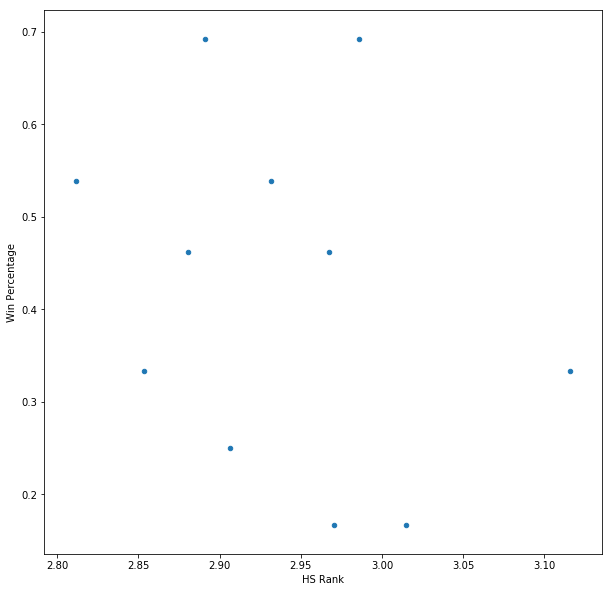

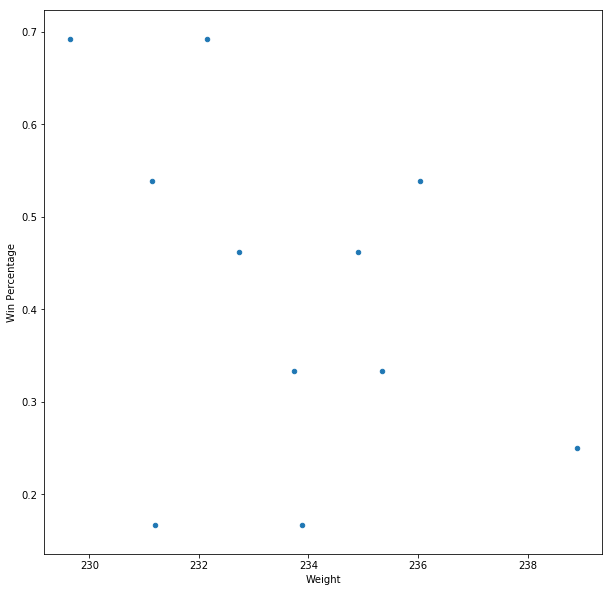

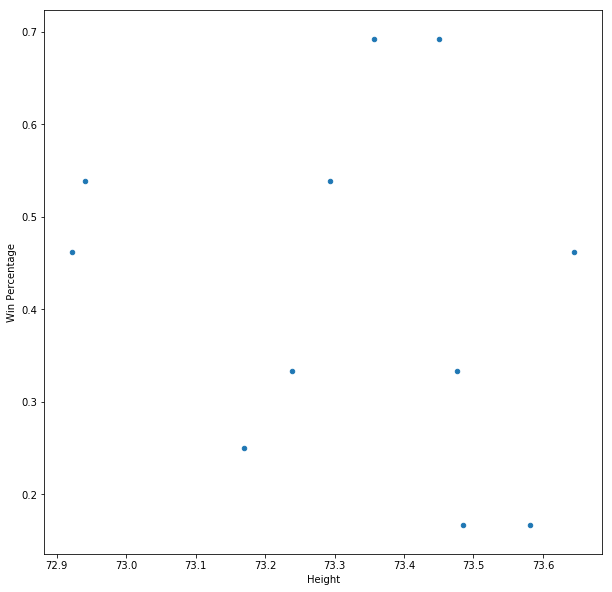

In [99]:
import matplotlib.pyplot as plt
%matplotlib inline

player_df['Height'] = player_df['Height'].astype(float)
player_df['Win Percentage'] = player_df['Win Percentage'].astype(float)
avg_rank_df = player_df.groupby('Season',as_index=False).mean()
avg_rank_df = avg_rank_df[player_df['Season'] != str(2008)]
avg_rank_df = avg_rank_df.drop('Jersey Num', 1)

fig, ax = plt.subplots(figsize=(10,10),squeeze=True)
avg_rank_df.plot(kind='scatter',x='HS Rank',y='Win Percentage',ax=ax)
fig, ax = plt.subplots(figsize=(10,10),squeeze=True)
avg_rank_df.plot(kind='scatter',x='Weight',y='Win Percentage',ax=ax)
fig, ax = plt.subplots(figsize=(10,10),squeeze=True)
avg_rank_df.plot(kind='scatter',x='Height',y='Win Percentage',ax=ax)

Much to my surprise, there was a negative correlation between all three variables: the higher the weight, height and rating, the lower the overall score of the season! 

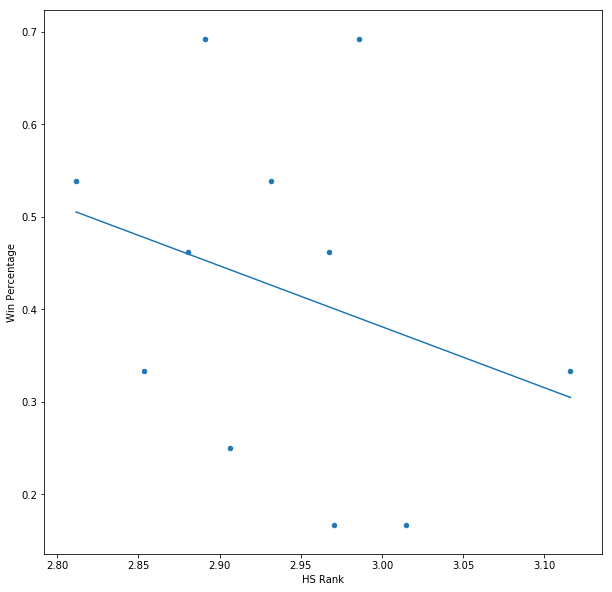

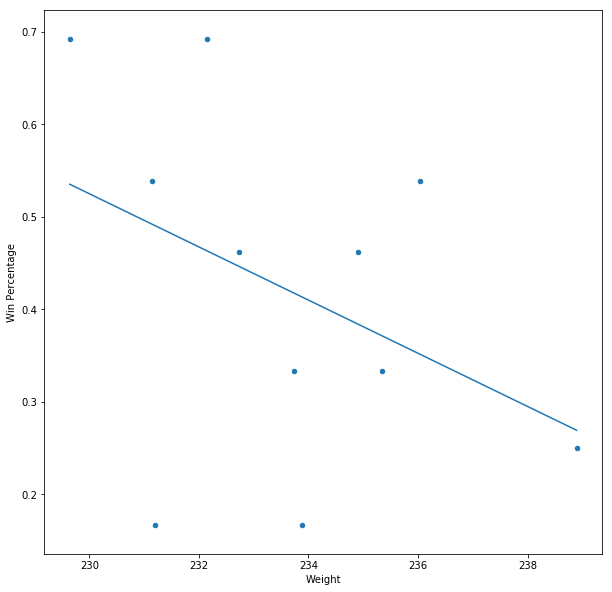

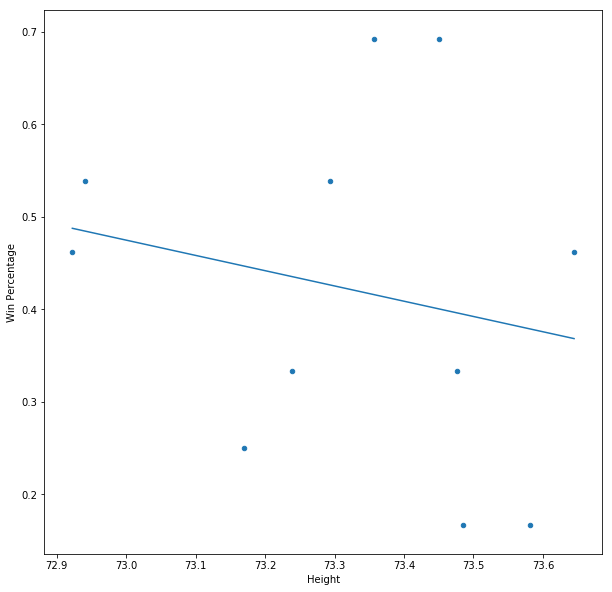

In [110]:
x = np.linspace(avg_rank_df['HS Rank'].min(),avg_rank_df['HS Rank'].max())
m, b = np.polyfit(avg_rank_df['HS Rank'], avg_rank_df['Win Percentage'], 1)
fig, ax = plt.subplots(figsize=(10,10),squeeze=True)
avg_rank_df.plot(kind='scatter',x='HS Rank',y='Win Percentage',ax=ax)
plt.plot(x, m*x + b, '-')

x = np.linspace(avg_rank_df['Weight'].min(),avg_rank_df['Weight'].max())
m, b = np.polyfit(avg_rank_df['Weight'], avg_rank_df['Win Percentage'], 1)
fig, ax = plt.subplots(figsize=(10,10),squeeze=True)
avg_rank_df.plot(kind='scatter',x='Weight',y='Win Percentage',ax=ax)
plt.plot(x, m*x + b, '-')

x = np.linspace(avg_rank_df['Height'].min(),avg_rank_df['Height'].max())
m, b = np.polyfit(avg_rank_df['Height'], avg_rank_df['Win Percentage'], 1)
fig, ax = plt.subplots(figsize=(10,10),squeeze=True)
avg_rank_df.plot(kind='scatter',x='Height',y='Win Percentage',ax=ax)
plt.plot(x, m*x + b, '-')

## References

### 2017 Roster
http://www.umterps.com/SportSelect.dbml?DB_OEM_ID=29700&SPID=120713&SPSID=716328&KEY=&Q_SEASON=2017

### 2017 Offensive/Defensive Stats
http://www.espn.com/college-football/team/stats/_/id/120/year/2017

### 2017 Maryland Football Commits
https://maryland.247sports.com/Season/2017-Football/Commits

### Maryland Football Digital Media Guide
http://www.umterps.com/ViewArticle.dbml?DB_OEM_ID=29700&ATCLID=208125975

### Maryland Football Head Coach Salaries
https://herosports.com/college-football/coaches-salary/dj-durkin
https://herosports.com/college-football/coaches-salary/randy-edsall
https://herosports.com/college-football/coaches-salary/ralph-friedgen

### Maryland NFL Players (Past & Present)
http://www.umterps.com/ViewArticle.dbml?&DB_OEM_ID=29700&ATCLID=208126633